# DSCI 100 Project Report
## K-NN Algorithm on Greek Alphabet Classification with Hilbert Curve Linearization

## Introduction

The most common way of linearizing images into a single-row feature vector is the zig-zag pattern linearization that simply concatenates an image matrix row-by-row. However, this linearization method entails the loss of proximity features, i.e. pixels that are originally close together, forming certain local features, will no longer be in each other's vicinity after linearization. However, in practice, not preserving these local features might just be one of the reasons why the K-NN classification model is insufficient in practice. K-NN algorithm uses a distance function, which sees features (pixels) as independent values, in conjunction with the majority principle to determine the class of some unseen data and makes no attempt to learn from the underlying patterns among the pixels, ungracefully disregarding the structure of the data (e.g. how pixels are arranged and collectively form macroscopic features, etc.). This renders the K-NN algorithm noise-sensitive and easily gullible, because even just small perturbations, imperceptible to human vision, can greatly impact how it classifies images: it will be extremely difficult for the model to clearly distinguish two images of the same object that differ a lot from one another for almost every pixel (e.g. different lighting, different perspectives, etc.). We have already seen from practice that the performance of a K-NN classification model on the small MNIST dataset still have a long way to go before it becomes practicable. Having inspired by research attempting to implement local feature preservation with K-NN models (Amato & Falchi, 2010), we reckon that, without compromising the intuitiveness of the K-NN algorithm, choosing a linearization method that preserves local features for the K-NN classification model could potentially improve its performance in a Greek Alphabet classification task. Out of all the space-filling curves, Hilbert curve is chosen for its phenomenal locality-preserving capability (Moon et al., 2001): most, if not all, pairs of pixel points on an image mapped by a Hilbert curve will remain close after the image matrix is straightened into a one-dimensional feature vector.

#### Research Question
Whether linearizing images with Hilbert Curve would improve the performance of a K-NN model on a Greek alphabet classification task.

#### Dataset: Handwritten Greek Letters
This is a 24-class balanced handwritten Greek Letters dataset. It consists of 24 classes (24 Greek letters) with 240 training images (10 for each class) and 96 testing images (4 for each class). The images are greyscale and clearly legible: black pen strokes on white backgrounds. The low-resolution images (14x14) will be used for the classification task. The last column of the two `csv` files are the ground truths. Since mapping with Hilbert curve requires images of the size $2^n\times2^n, n\in\mathbb{Z}^+$ (a square image of width $N$ can be mapped by a $\log_2(N)$'th order Hilbert curve), we will be padding all images by 1 pixel for all four sides.

## Methodology

We would like to see if training K-NN classification models with images linearized with Hilbert curve would significantly and consistently improve the model's performance for all $K$ values, measured using validation accuracies. To investigate this, we will create two copies of the data set, each corresponding to a condition:
1. Regular set (control): all images within the set are regularly linearized using the classic zig-zag mapping.
2. Hilbert set (experimental): all images within the set are mapped and linearized using a 4-th order Hilbert curve.

> To avoid redundancy, the two conditions/models will be referred to as the Baseline Model/Condition (regular linearization) and the HC Model/Condition (Hilbert curve linearization) respectively thereinafter.

All feature vectors (images) in both data sets will be compressed such that every adjacent feature are averaged to form a new feature vector of the size one less than that of its original, embeding the order information within the data.

With a stratified 5-fold cross validation, we will use these two data sets to train and test two separate instances of the K-NN classification model respectively, all the while resampling with varying $K$ values within the interval $[2,51]$ at a step of $1$.

All random processes, including but not limited to data augmentation and cross validation split, will be made deterministic and reproducible by setting an arbitrarily-chosen global seed (`2023`) to eradicate test results variability due to randomness and ensure that we are always taking the same sample from the population.

Some of the details will be further elaborated.

### Hypothesis Testing
**Parameter of Interest**: The population mean difference in validation accuracies (denoted by $\Delta_{acc}$) of the Baseline Model and the HC Model.

**Null Hypothesis**: $H_0:\Delta_{acc}=0$  
There is no significant difference in population mean difference of validation accuracies of the Baseline Model and the HC Model.

**Alternative Hypothesis**: $H_A:\Delta_{acc}>0$  
There is significant improvement in the model's validation accuracies under the HC Condition compared to the Baseline Condition.

The final accuracies will be paired recorded in a 50x4 table as follows:

$$
\def\arraystretch{1.5}
\begin{array}{|c|c|c|c|}
    \hline
    K & \text{Baseline} & \text{HC} & \Delta_{acc} \\ \hline
    2 & 0.83 & 0.84 & 0.01 \\
    3 & 0.85 & 0.82 & -0.03 \\
    \vdots & \vdots & \vdots & \vdots \\
    51 & 0.78 & 0.80 & 0.02 \\ \hline
\end{array}
$$

Assuming that observations are randomly drawn from the population, dependent within-pair, and independent pair-to-pair, and that the sample size ($n=50$) is sufficiently large but not exceeding 10% of the population size, we will be using a right-tailed one-sample $t$-test on the mean differences in validation accuracies $\Delta_{acc}$ (a.k.a. paired $t$-test) to test for its significance. The hypothesis test will be conducted at the significance level $\alpha=0.1$ (90% confidence level). $H_0$ will be rejected only if $p<\alpha$, where $p$ is the $p$-value.

### Visualization
1. An accuracy vs. $K$ line plot will be plotted with both conditions on the same plot to not only show the change of accuracy in response to different $K$'s in both conditions but also compare the performance of the two models at different $K$'s.
2. A histogram with an overlayed density line (Kernel Density Estimation) to show the distribution of the accuracy differences.

## Data Analysis

### Data Processing

Loading the required packages: `tidyverse` and `tidymodels`.

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.2.0
✔ recipes      1.0.6     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Getting Started

We created helper functions specifically for this project in a separate R script to avoid crowding this notebook with too many lines of code. The raw script will be loaded from [here](https://raw.githubusercontent.com/4g3nt81lly/Group68-Project/main/src/helpers.R).

Here's a brief summary of our helper functions in the context of our project (the docstrings can be found in the raw script file):
- `hilbert.coordinate`: an iterative implementation (referenced [this article](https://blog.marcinchwedczuk.pl/iterative-algorithm-for-drawing-hilbert-curve)) of generating the coordinate of a $\log_2(N)$'th-order Hilbert curve at a given index -- the index goes from 0 to 255 (16x16 image).  
    > This will be used to generate the Hilbert curve map.
- `hilbert.curve.demo`: displays a demo for what the Hilbert curve looks like.
- `get.summary`: get a summary data frame of a given pair of training/testing data sets.
    > This is used to show class distributions of the raw training/testing data sets.
- `augment.set`: perform data augmentation on an image set, generating an altered copy of the dataset with the given transformation function.
    > This will be used to extend our dataset to ensure that a sufficient number of samples are supplied for each class in a stratified 5-fold cross validation.
- `show.image`: displays the `i`'th image from a given dataset.
- `X.padding`: perform image padding with a custom value, or a random range.
    > This will be used to convert 14x14 images to 16x16 images.
- `rotate.image`: rotate an image matrix by an integer multiple of 90˚ clockwise.
- `gaussian.noise`: add Gaussian noise to a given image matrix.

Some will be elaborated further.

Load the helper functions before starting:

In [2]:
source('src/helpers.R')

In [3]:
# setting up seed for reproducibility
set.seed(2023)

# side length constant for 16x16 images
N <- 16

#### Loading and Preparing Datasets

Now we will load the raw training/testing datasets from URLs, the last column has the labels and it will be converted to factor:

In [4]:
dataset.path.prefix <- 'handwritten-greek-letters/'
training.set.path <- paste0(dataset.path.prefix, 'train.csv')
testing.set.path <- paste0(dataset.path.prefix, 'test.csv')

# class labels
greek.alphabet <- c('α', 'β', 'γ', 'δ', 'ε', 'ζ',
                    'η', 'θ', 'ι', 'κ', 'λ', 'μ',
                    'ν', 'ξ', 'ο', 'π', 'ρ', 'σ',
                    'τ', 'υ', 'φ', 'χ', 'ψ', 'ω')

raw.training.set <- read_csv(training.set.path, col_names = FALSE,
                             show_col_types = FALSE) |>
    # convert ground truth column to factor and rename it
    mutate(label = as_factor(greek.alphabet[X197]), .keep = 'unused')

raw.testing.set <- read_csv(testing.set.path, col_names = FALSE,
                            show_col_types = FALSE) |>
    mutate(label = as_factor(greek.alphabet[X197]), .keep = 'unused')

print('Table 1: Raw training set (preview)')
head(raw.training.set)
print('Table 2: Raw testing set (preview)')
head(raw.testing.set)

[1] "Table 1: Raw training set (preview)"


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X188,X189,X190,X191,X192,X193,X194,X195,X196,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
255,247,251,255,249,255,245,254,254,254,⋯,255,253,254,255,255,245,255,238,255,α
252,255,249,254,253,255,255,247,254,255,⋯,241,255,253,248,255,255,255,255,234,α
244,255,253,246,255,248,255,249,251,249,⋯,255,255,255,255,239,255,255,252,255,α
255,246,255,246,255,255,243,255,255,233,⋯,247,255,247,246,248,255,255,243,247,α
251,255,255,249,255,255,249,251,254,255,⋯,255,235,255,245,255,248,255,255,240,α
247,255,255,253,255,255,252,255,255,243,⋯,255,237,243,255,251,255,238,251,243,α


[1] "Table 2: Raw testing set (preview)"


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X188,X189,X190,X191,X192,X193,X194,X195,X196,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
253,255,255,251,244,255,254,253,248,255,⋯,255,247,255,255,251,249,255,254,237,α
248,255,245,255,255,247,255,247,255,236,⋯,252,255,247,240,255,253,240,255,241,α
255,255,254,255,252,242,255,245,244,255,⋯,255,251,251,255,255,253,251,249,255,α
255,249,252,248,254,255,246,252,244,255,⋯,255,233,246,252,249,255,254,241,255,α
255,252,255,255,254,244,244,255,255,243,⋯,253,232,240,242,255,255,255,239,241,β
254,250,255,255,255,255,255,255,254,255,⋯,250,255,255,255,246,245,246,236,255,β


Here's a summary of the data sets at a glance:

In [5]:
# raw training/testing set summary
set.summary <- get.summary(raw.training.set, raw.testing.set)

print('Table 3: Summary of Raw Training/Testing Set')
set.summary

[1] "Table 3: Summary of Raw Training/Testing Set"


label,training,testing,total
<fct>,<int>,<int>,<int>
α,10,4,14
β,10,4,14
γ,10,4,14
δ,10,4,14
ε,10,4,14
ζ,10,4,14
η,10,4,14
θ,10,4,14
ι,10,4,14


Since a 5-fold cross validation will be used not to tune the model's parameters but to evaluate the model's performance, we will not need the train/test split, so here we will merge them into a single data set.

In [6]:
raw.data.set <- bind_rows(raw.training.set, raw.testing.set)

print(paste('Combined data set dimension:', nrow(raw.data.set), 'x', ncol(raw.data.set)))

[1] "Combined data set dimension: 336 x 197"


Notice that these data points are within the range $[0, 255]$ which can get quite large with white pixels (close to $255$) and hence not so easy to compute, especially when there are so many data, so we scale all the values to the range $[0,1]$.

In [7]:
# normalize data between [0, 1] for easier computation
scaled.data.set <- raw.data.set |>
    mutate(across(where(is.numeric), ~ . / 255))

print('Table 4: Scaled data set (preview)')
head(scaled.data.set)

[1] "Table 4: Scaled data set (preview)"


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X188,X189,X190,X191,X192,X193,X194,X195,X196,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.0000000,0.9686275,0.9843137,1.0000000,0.9764706,1.000000,0.9607843,0.9960784,0.9960784,0.9960784,⋯,1.0000000,0.9921569,0.9960784,1.0000000,1.0000000,0.9607843,1.0000000,0.9333333,1.0000000,α
0.9882353,1.0000000,0.9764706,0.9960784,0.9921569,1.000000,1.0000000,0.9686275,0.9960784,1.0000000,⋯,0.9450980,1.0000000,0.9921569,0.9725490,1.0000000,1.0000000,1.0000000,1.0000000,0.9176471,α
0.9568627,1.0000000,0.9921569,0.9647059,1.0000000,0.972549,1.0000000,0.9764706,0.9843137,0.9764706,⋯,1.0000000,1.0000000,1.0000000,1.0000000,0.9372549,1.0000000,1.0000000,0.9882353,1.0000000,α
1.0000000,0.9647059,1.0000000,0.9647059,1.0000000,1.000000,0.9529412,1.0000000,1.0000000,0.9137255,⋯,0.9686275,1.0000000,0.9686275,0.9647059,0.9725490,1.0000000,1.0000000,0.9529412,0.9686275,α
0.9843137,1.0000000,1.0000000,0.9764706,1.0000000,1.000000,0.9764706,0.9843137,0.9960784,1.0000000,⋯,1.0000000,0.9215686,1.0000000,0.9607843,1.0000000,0.9725490,1.0000000,1.0000000,0.9411765,α
0.9686275,1.0000000,1.0000000,0.9921569,1.0000000,1.000000,0.9882353,1.0000000,1.0000000,0.9529412,⋯,1.0000000,0.9294118,0.9529412,1.0000000,0.9843137,1.0000000,0.9333333,0.9843137,0.9529412,α


#### Exploratory Analysis

To be added...

Explore Distributions of Features: Generate histograms or box plots to visualize the distribution of each feature across different classes in order to identify patterns or variations.

And here's a pie chart of class distributions of the training/testing data sets.

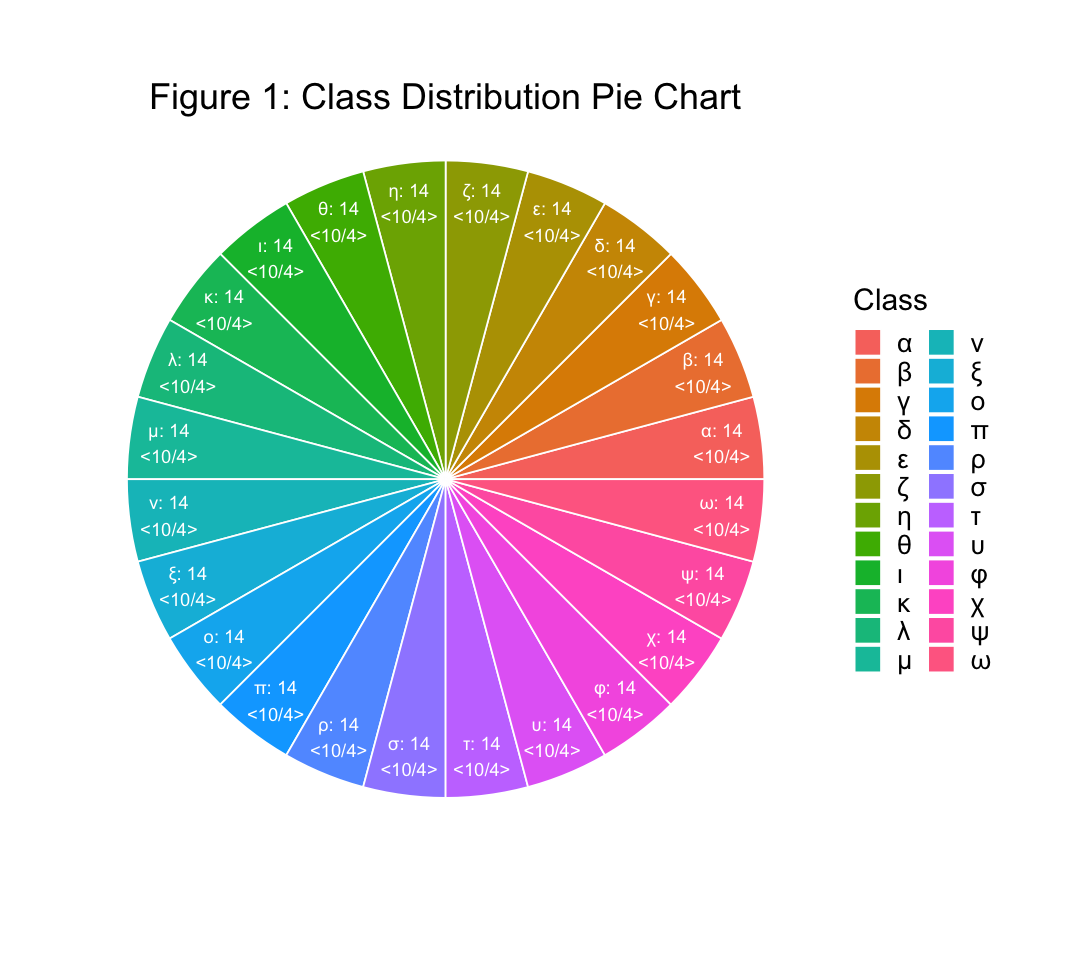

In [8]:
options(repr.plot.width = 9, repr.plot.height = 8)
set.summary |> ggplot(aes(x = '', y = total, fill = label)) +
    geom_bar(stat = 'identity', width = 2, color = 'white') +
    geom_text(aes(label = paste0(label, ': ', total, '\n',
                                 '<', training, '/', testing, '>'),
                  x = 1.75),
              position = position_stack(vjust = 0.5), color = 'white') +
    coord_polar(theta = 'y', start = pi / 2) +
    labs(title = 'Figure 1: Class Distribution Pie Chart', fill = 'Class') +
    theme_void() +
    theme(text = element_text(size = 18),
          plot.title = element_text(hjust = 0.5, margin = unit(c(0, 0, -0.75, 0), 'cm')),
          legend.text = element_text(size = 16),
          plot.margin = margin(l = 1, r = 2, unit = 'cm'))

From the pie chart above, the classes are perfectly balanced.

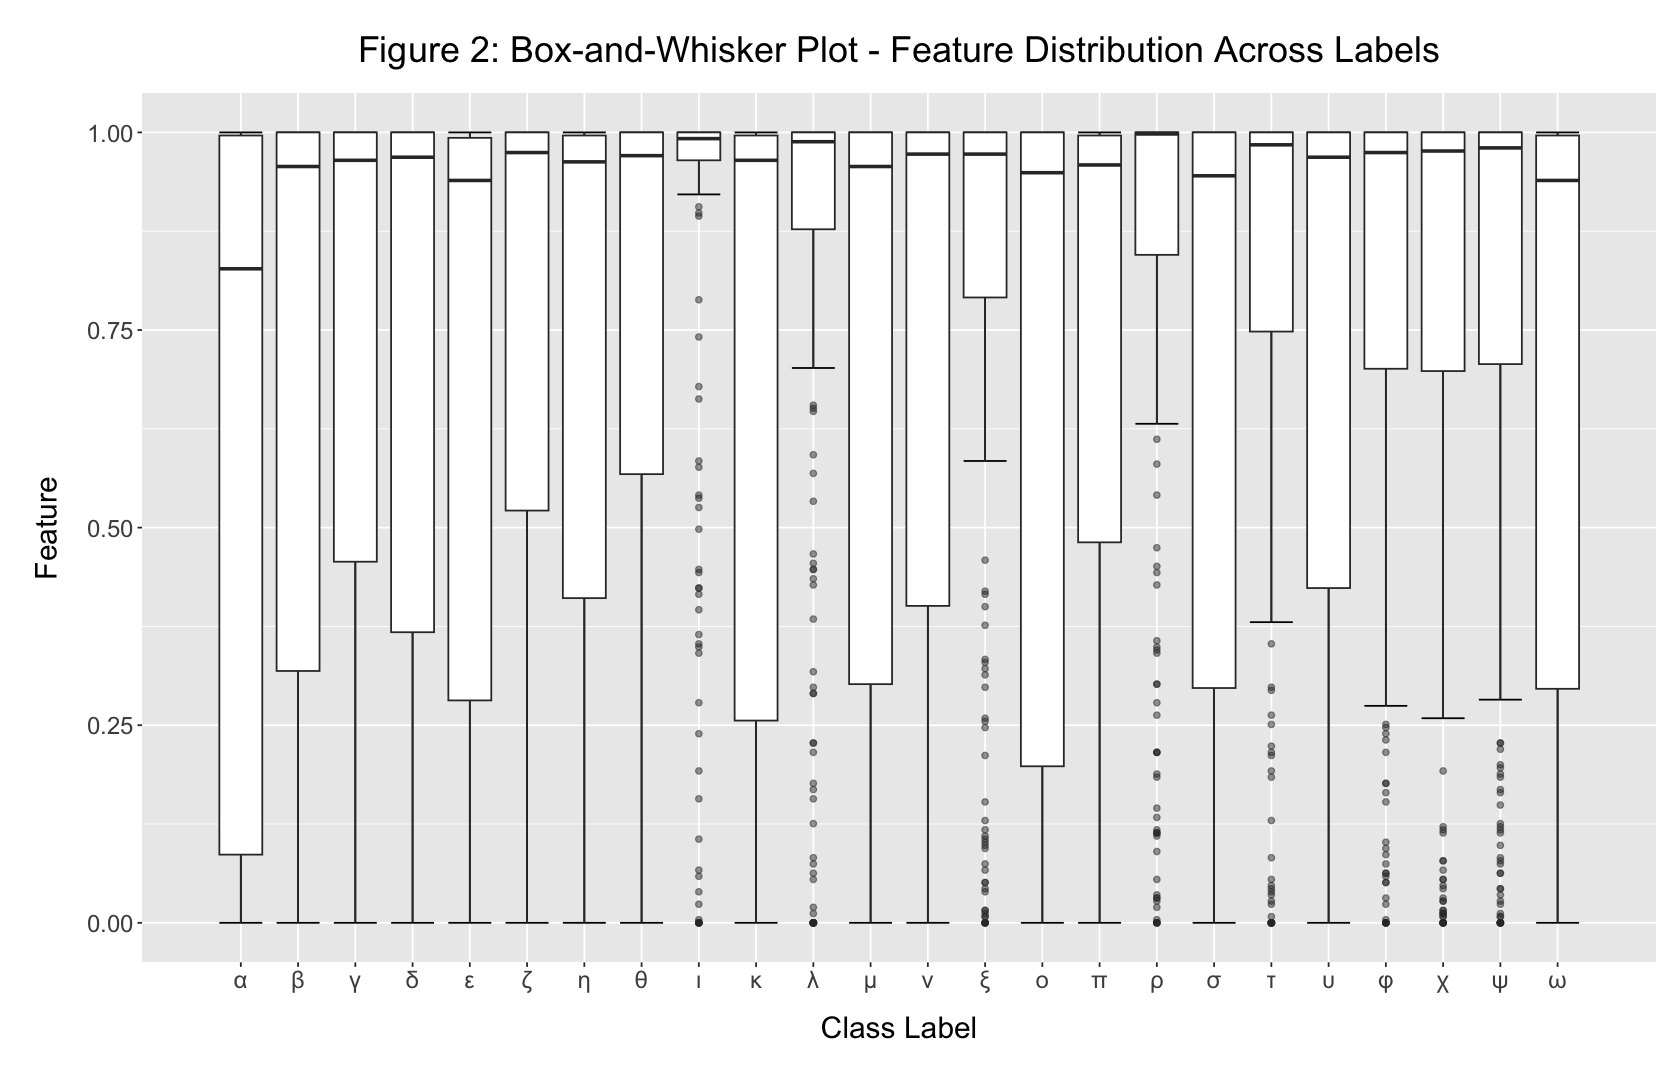

In [9]:
options(repr.plot.width = 14, repr.plot.height = 9)

scaled.data.set |>
    group_by(label) |>
    slice_sample(n = 1) |>
    pivot_longer(cols = X1:X196,
                 names_to = NULL,
                 values_to = 'feature') |>
    ggplot(aes(x = label, y = feature)) +
        stat_boxplot(geom = 'errorbar', width = 0.75) +
        geom_boxplot(width = 0.75, outlier.alpha = 0.5) +
        scale_x_discrete(expand = c(0.075, 0)) +
        labs(title = 'Figure 2: Box-and-Whisker Plot - Feature Distribution Across Labels',
             x = 'Class Label', y = 'Feature') +
        theme(text = element_text(size = 18),
              plot.title = element_text(hjust = 0.5, margin = unit(c(0, 0, 0.5, 0), 'cm')),
              axis.title.x = element_text(margin = unit(c(0.5, 0, 0, 0), 'cm')),
              axis.title.y = element_text(margin = unit(c(0, 0.5, 0, 0), 'cm')),
              legend.position = 'right',
              plot.margin = margin(t = 0.75, b = 0.75, l = 0.75, r = 0.5, unit = 'cm'))

Here we sampled one image from each class label at random and compare their distributions.

From the boxplots above, all distributions are left-skewed towards the right end, and most distributions have 50% of their features gathered quite densely near the right end (1.00, white pixels): this means that for most images, across all classes, half of the images tend to be lighter pixels (white backgrounds) and the other half of the features spread very widely from 0.0 to around 0.88 (less than half of the image features belong to pen strokes). This pattern indicates that many of the features do not contribute to the patterns of the characters and may act like noises to the classification model, and they are potentially associated with decreased classification performance. Some of the classes have darker pixels not within its interquartile range but as outliers, implying that only a small portion of the data are part of the handwritten letters and a very large portion of the features (even higher than images of the other classes) are not part of the pen strokes, for instance letters $\iota$ and $\tau$ which are reasonable because they are inherently smaller symbols after all. Other not-so-small symbols that also share this pattern such as $\phi$ and $\psi$ may suggest that the way in which they were handwritten will be generally relatively smaller in size (hence less darker pixels) than usual in practice.

#### Image Upscaling

Now, the raw datasets are ready. But just before that, since Hilbert curve linearization only works with square images of the side length $2^n$ where $n\in\mathbb{Z}^+$, we have to convert 14x14 images to 16x16, the closest exponent of 2. To achieve this, we will apply padding on our images. Padding is a technique used to add pixels to expand/reduce the dimension of an image. In this context, we will be adding 1 layer of random numbers within the range $[0.95, 1]$ (white pixels with slightly-varying brightness) to upscale the images to 16x16. Random numbers are preferred because the images would be much more natural and less artificial than just a pure white border.

In [10]:
upscale.to.16x16 <- function(data.set) {
    # new matrix for storing processed images (16x16 feature vectors)
    upscaled.images <- matrix(, nrow = 0, ncol = N ^ 2)
    
    # exclude label column and convert to a matrix for a faster computation
    # this is dramatically faster than manipulating the data frame directly
    image.set <- data.set |>
        select_if(is.numeric) |>
        as.matrix()
    
    for (row.no. in seq_len(nrow(data.set))) {
        upscaled <- image.set[row.no., ] |>
            as.image.matrix(ncol = 14) |>
            X.padding(x = c(0.95, 1), random = TRUE) |>
            as.feature.vector()
        # add row to new matrix
        upscaled.images <- rbind(upscaled.images, upscaled)
    }
    # convert to data frame
    upscaled.images <- as.data.frame(upscaled.images) |>
        `colnames<-`(paste0('X', 1:(N ^ 2))) |>
        `rownames<-`(NULL)
    # add the label column
    upscaled.images <- bind_cols(upscaled.images, label = data.set$label)
    
    return(upscaled.images)
}

We will apply the function to both training/testing sets:

In [11]:
x16.data.set <- upscale.to.16x16(scaled.data.set)

print('Table 5: 16x16 data set (preview)')
head(x16.data.set, n = 3)

[1] "Table 5: 16x16 data set (preview)"


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X248,X249,X250,X251,X252,X253,X254,X255,X256,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.9998442,0.9878765,0.9831796,0.9862181,0.9729473,0.9837199,0.9850257,0.9907536,0.9845591,0.9858206,⋯,0.9516158,0.9724145,0.9632366,0.9704634,0.9597298,0.9771744,0.9967552,0.9887019,0.9741863,α
2,0.9878489,0.9878136,0.9610806,0.9995590,0.9989865,0.9929515,0.9620757,0.9815666,0.9872023,0.9887202,⋯,0.9994361,0.9953061,0.9509720,0.9776693,0.9670798,0.9815355,0.9809149,0.9961471,0.9614082,α
3,0.9513614,0.9733919,0.9532841,0.9725014,0.9585046,0.9674443,0.9776169,0.9753356,0.9729116,0.9565009,⋯,0.9810473,0.9876101,0.9919954,0.9734465,0.9651147,0.9697876,0.9604897,0.9961168,0.9748383,α


Here's a visual comparison before and after the padding:

[1] "Figure 3: Image comparison before and after padding"


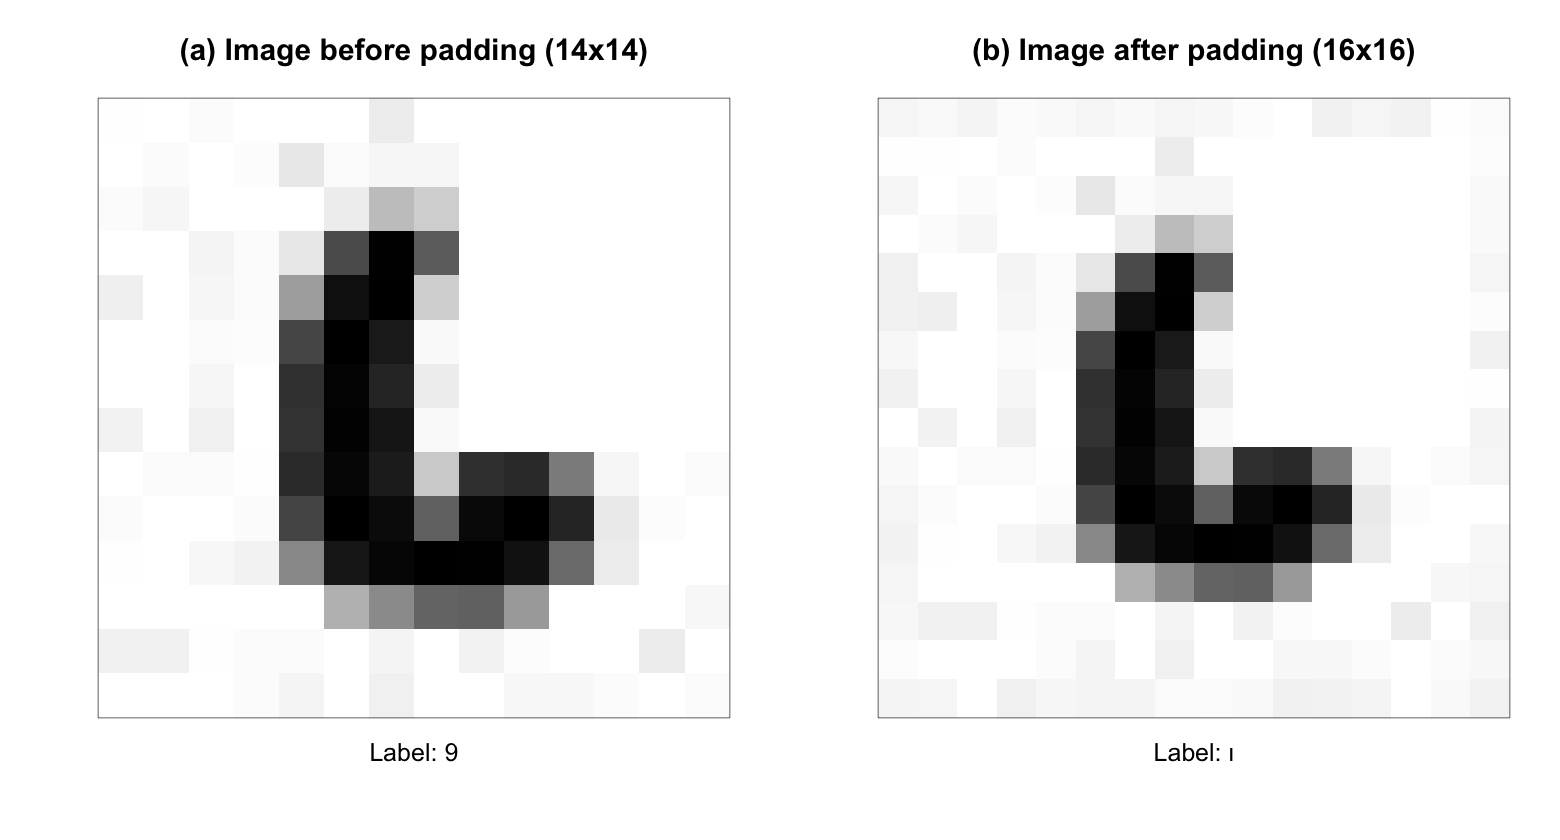

In [12]:
options(repr.plot.width = 13, repr.plot.height = 7)
par(mfrow = c(1, 2))
random.i <- sample(seq_len(nrow(scaled.data.set)), 1)

print('Figure 3: Image comparison before and after padding')
show.image(scaled.data.set, n = 14, i = random.i,
           main = '(a) Image before padding (14x14)')
show.image(x16.data.set, i = random.i,
           main = '(b) Image after padding (16x16)')

#### Data Augmentation

Research have shown that small training sample size negatively impacts the performance of classification models (Assegie, 2022). Since we will be using a stratified 5-fold cross validation to evaluate the performance of the model, we need to make sure that each class within each split of the cross-validation has sufficient amount of data to be used for training and validating. With the current size $n=24\cdot(10+4)=336$, performing a stratified 5-fold cross validation will result in:
- uneven folds: 67 images for 4 folds and 68 images for the last fold;
- uneven proportion of classes within each fold: neither of the numbers 67 and 68 can be evenly divided by 24 (the number of classes);
- insufficient data for each class: around 11 images per class in training set and 2-3 images per class in validation set.

We will perform data augmentation to expand our data set. Data augmentation is a technique often used in machine learning to extend data sets and avoid overfitting by introducing variations (e.g. rotation, translation, rescaling, distortion, etc.) of the existing data.

Without making the computation excessively expensive, the smallest integer by which the current size can be multiplied to produce perfectly even folds and proportion of classes within each fold is $5$ ($336\times5=1680$):
- 336 images per fold;
- 56 images per class in training set and 14 images per class in validation set

This means that we need 4 more augmented copies of our current data set. Here are two of the easiest augmentation we will apply:
1. Rotation by an odd integer multiple of 90˚ clockwise  
    We choose 90˚ and 270˚ clockwise (-90˚).
    > A rotation by an even integer multiple of 90˚ clockwise does not alter the image since both linearization methods have order 2 rotational symmetry: images pre- and post-rotation will appear to be the same to the model.
    
    Here's a demo:

[1] "Figure 4: Image comparison before and after rotation"


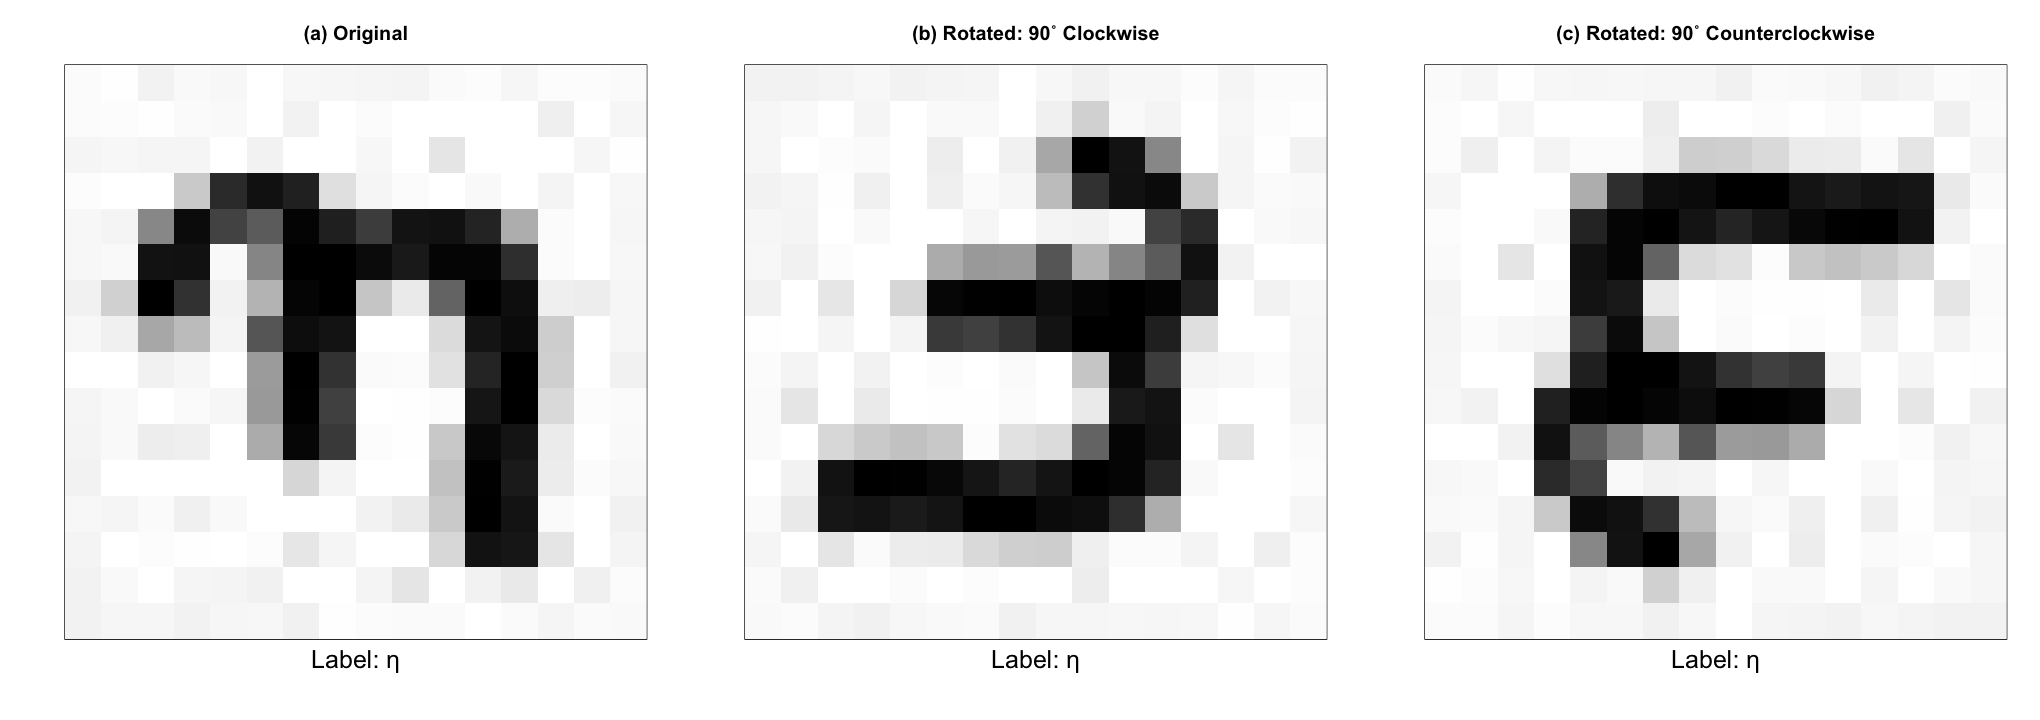

In [13]:
options(repr.plot.width = 17, repr.plot.height = 6)
par(mfrow = c(1, 3))
random.i <- sample(seq_len(nrow(x16.data.set)), 1)

print('Figure 4: Image comparison before and after rotation')
show.image(x16.data.set, i = random.i,
           main = '(a) Original')
x16.data.set |> augment.set(rotate.image) |>
    show.image(i = random.i,
               main = '(b) Rotated: 90˚ Clockwise')
x16.data.set |> augment.set(rotate.image, angle = -90) |>
    show.image(i = random.i,
               main = '(c) Rotated: 90˚ Counterclockwise')

2. Gaussian Noise  
    We will add statistical noise that follows a standard Gaussian distribution with two variations in its standard deviation (mean remains 0).  
    Here's a demo:

[1] "Figure 5: Image comparison before and after applying Gaussian noise"


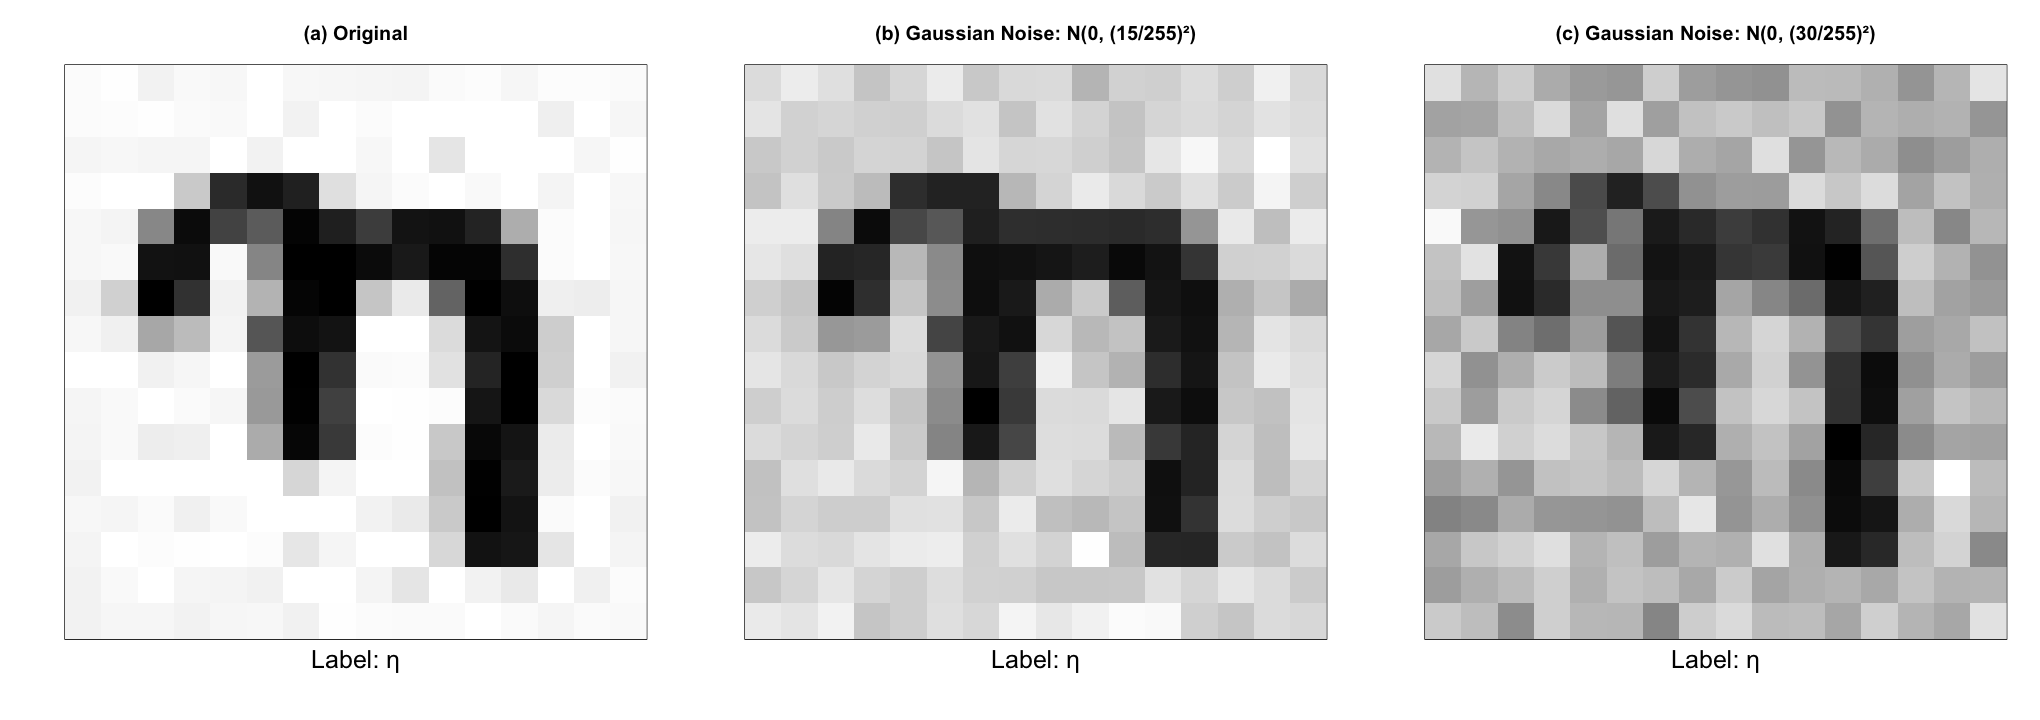

In [14]:
options(repr.plot.width = 17, repr.plot.height = 6)
par(mfrow = c(1, 3))

print('Figure 5: Image comparison before and after applying Gaussian noise')
show.image(x16.data.set, i = random.i,
           main = '(a) Original')
x16.data.set |> augment.set(gaussian.noise, sd = 15 / 255) |>
    show.image(i = random.i,
               main = '(b) Gaussian Noise: N(0, (15/255)²)')
x16.data.set |> augment.set(gaussian.noise, sd = 30 / 255) |>
    show.image(i = random.i,
               main = '(c) Gaussian Noise: N(0, (30/255)²)')

We will now apply our augmentation on the data set:

In [15]:
custom.augmentation <- function(data.set) {
    data.set |> bind_rows(
        # clockwise 90 degrees
        data.set |> augment.set(fn = rotate.image),
        # counterclockwise 90 degrees
        data.set |> augment.set(fn = rotate.image, angle = -90),
        # gaussian noise with 2 different SDs downscaled by 255
        data.set |> augment.set(fn = gaussian.noise, sd = 10 / 255),
        data.set |> augment.set(fn = gaussian.noise, sd = 25 / 255),
    )
}

x16.augmented.set <- x16.data.set |> custom.augmentation()

print(paste('New dimension:', nrow(x16.augmented.set), 'x', ncol(x16.augmented.set)))
print('Table 6: Augmented data set (tail preview)')
tail(x16.augmented.set, n = 3)

[1] "New dimension: 1680 x 257"
[1] "Table 6: Augmented data set (tail preview)"


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X248,X249,X250,X251,X252,X253,X254,X255,X256,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1678,1.0539805,0.9539714,0.8383886,0.9059697,0.9767277,0.7797427,1.1090278,1.056513,1.0465659,1.1314649,⋯,0.8900603,1.0250423,1.0360280,0.9066847,0.9885409,0.9221514,0.9454506,1.090183,1.031016,ω
1679,0.9657320,0.9121018,1.0127130,0.8663421,1.0133801,0.8558548,0.9511574,0.981628,1.0183271,0.9246136,⋯,0.9657223,0.9625855,0.9917215,0.9477073,0.9634124,0.8843204,0.8236821,1.076491,1.046097,ω
1680,0.8525762,1.0495029,1.1049886,1.0479635,1.1358597,1.1202350,0.8036522,1.065516,0.9875096,1.0135403,⋯,0.8742634,1.0968162,1.1452806,0.8408070,1.1351267,1.0487238,0.9480276,0.993417,1.036758,ω


#### Applying Linearizations

Since there will be two conditions, we'll need two versions of the datasets:
1. Baseline Condition: the image matrix is linearized via row-by-row concatenation.
2. HC Condition: the image matrix is linearized in the sequence of a 4th-order Hilbert curve.

For computational efficiency, we will create a Hilbert curve map that contains pre-generated coordinates so that we don't have to regenerate the coordinates everytime we are linearizing the images or decoding images stored in the sequence of a Hilbert curve.
> NOTE: The coordinates are converted to R's 1-based indexing.

In [16]:
hilbert.map <- get.hilbert.map(N)

print('Hilbert map (preview)')
head(hilbert.map)

[1] "Hilbert map (preview)"


x,y
<int>,<int>
1,1
2,1
2,2
1,2
1,3
1,4


In order to linearize images using Hilbert curve, a helper function was created to generate coordinates of a $\log_2(N)$'th-order Hilbert curve, here's what the curve looks like when plotted in a 2D euclidean space:

[1] "Figure 6: Hilbert map demo"


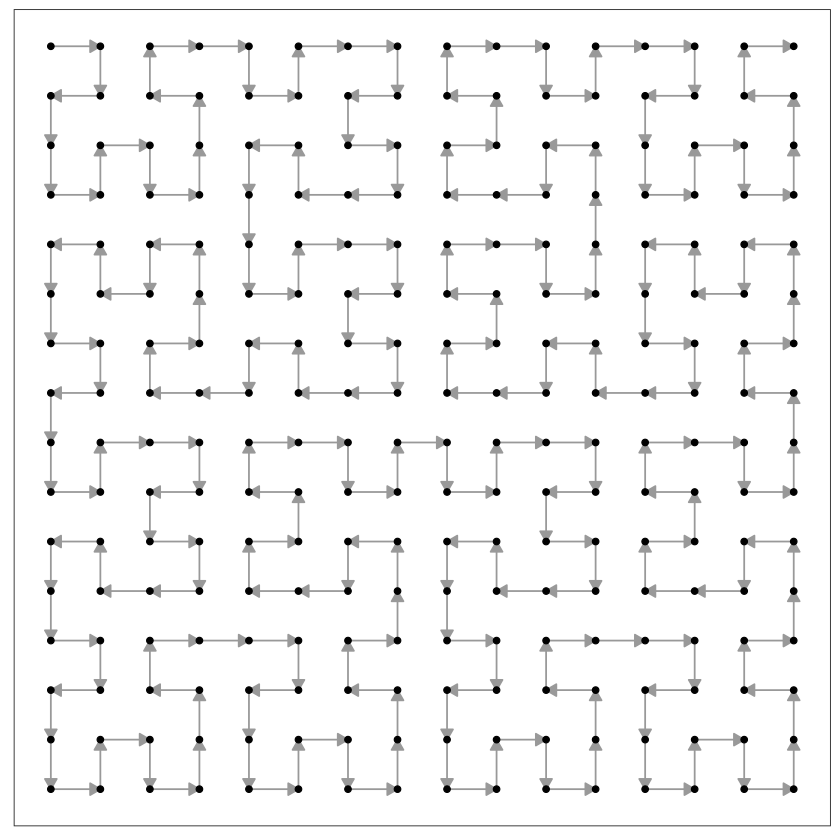

In [17]:
options(repr.plot.width = 7, repr.plot.height = 7)
print('Figure 6: Hilbert map demo')
hilbert.curve.demo(hilbert.map)

And here's how it's mapped onto an 16x16 image comparing to a regular linearization:

[1] "Figure 7: Comparison between linearization methods"


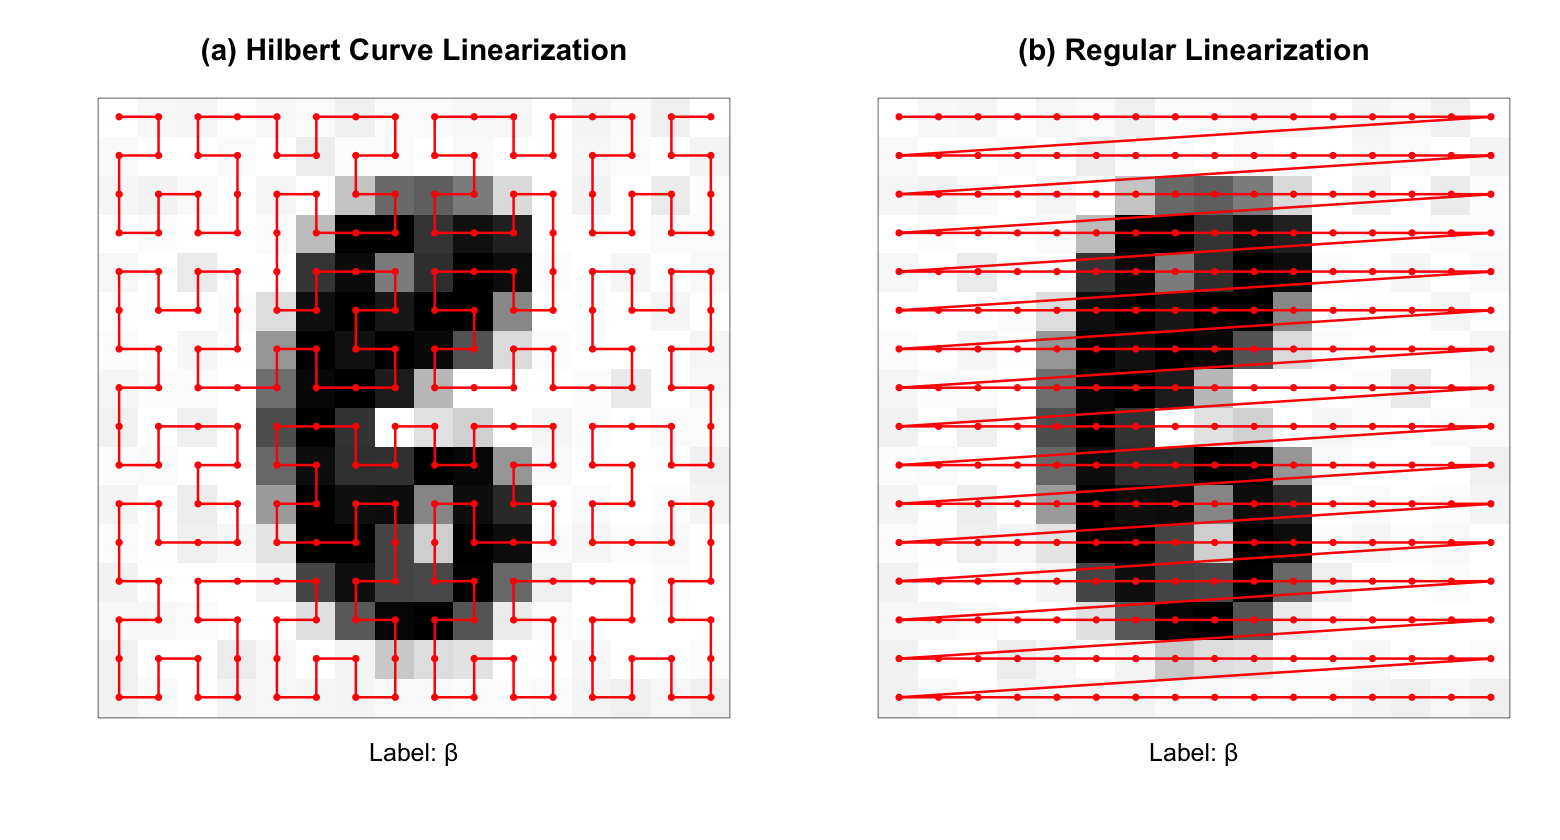

In [18]:
options(repr.plot.width = 13, repr.plot.height = 7)
par(mfrow = c(1, 2))
random.i <- sample(seq_len(nrow(x16.data.set)), 1)

print('Figure 7: Comparison between linearization methods')

hilbert.demo.coords <- hilbert.map |> 
    map_at('y', ~ N - . + 1) |>
    map_df(~ . / 15 - 0.065)
show.image(x16.data.set, i = random.i,
           main = '(a) Hilbert Curve Linearization')
points(hilbert.demo.coords$x, hilbert.demo.coords$y,
       pch = 20, col = 'red')

hilbert.demo.pairs <- hilbert.demo.coords |>
    get.coordinate.pairs()
segments(hilbert.demo.pairs$x0, hilbert.demo.pairs$y0,
         hilbert.demo.pairs$x1, hilbert.demo.pairs$y1,
         col = 'red', lwd = 2)


regular.demo.coords <- hilbert.demo.coords |>
    filter(x %in% c(min(x), max(x))) |>
    arrange(desc(y))
show.image(x16.data.set, i = random.i,
           main = '(b) Regular Linearization')
points(hilbert.demo.coords$x, hilbert.demo.coords$y,
       pch = 20, col = 'red')

regular.demo.pairs <- regular.demo.coords |>
    get.coordinate.pairs()
segments(regular.demo.pairs$x0, regular.demo.pairs$y0,
         regular.demo.pairs$x1, regular.demo.pairs$y1,
         col = 'red', lwd = 2)

The images in `x16.augmented.set` have already been regularly linearized and no further processing is needed, we'll rename it so that it's clear.

In [19]:
regular.data.set <- x16.augmented.set
rm(x16.augmented.set)

We will now apply HC linearization on the `regular.data.set` to create a copy of the data set for the HC Condition.

In [20]:
linearize.hilbert <- function(data.set) {
    # new matrix for processed images (16x16, mapped by Hilbert curve)
    processed.images <- matrix(, nrow = 0, ncol = N ^ 2)
    
    # exclude label column and convert to a matrix for a faster computation
    image.set <- data.set |>
        select_if(is.numeric) |>
        as.matrix()
    
    # store pixels in the sequence of an log_2(N)-order Hilbert curve
    for (row.no. in seq_len(nrow(data.set))) {
        image.matrix <- image.set[row.no., ] |>
            as.image.matrix(ncol = N)
        # get corresponding pixels 
        image.vector <- hilbert.map |>
            rowwise() |>
            mutate(pixel = image.matrix[y, x]) |>
            pull(pixel) |>
            as.numeric()
        # add row to new matrix
        processed.images <- processed.images |> rbind(image.vector)
    }
    # convert to data frame and return
    processed.images <- as.data.frame(processed.images) |>
        `colnames<-`(paste0('X', 1:(N ^ 2))) |>
        `rownames<-`(NULL)
    
    # add the label column
    processed.images <- bind_cols(processed.images, label = data.set$label)
    
    return(processed.images)
}

In [21]:
hilbert.data.set <- linearize.hilbert(regular.data.set)

print('Table 7: HC linearized data set (preview)')
head(hilbert.data.set, n = 3)

[1] "Table 7: HC linearized data set (preview)"


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X248,X249,X250,X251,X252,X253,X254,X255,X256,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.9998442,0.9878765,1.0000000,0.9911313,0.9695853,0.9692625,0.9921569,0.9725490,1.0000000,0.9843137,⋯,0.9725490,1.0000000,1.0000000,0.9618846,0.9917689,0.9564335,0.9764706,0.9617557,0.9935299,α
2,0.9878489,0.9878136,0.9882353,0.9626213,0.9919234,0.9719363,0.9803922,0.9921569,1.0000000,0.9960784,⋯,0.9764706,0.9803922,1.0000000,0.9549490,0.9926292,0.9877642,1.0000000,0.9872709,0.9677549,α
3,0.9513614,0.9733919,0.9568627,0.9606518,0.9541198,0.9676313,0.9568627,1.0000000,0.9764706,0.9882353,⋯,1.0000000,1.0000000,0.9843137,0.9522856,0.9602362,0.9555924,0.9921569,0.9817697,0.9704205,α


[1] "Figure 8: Image comparison between linearization methods"


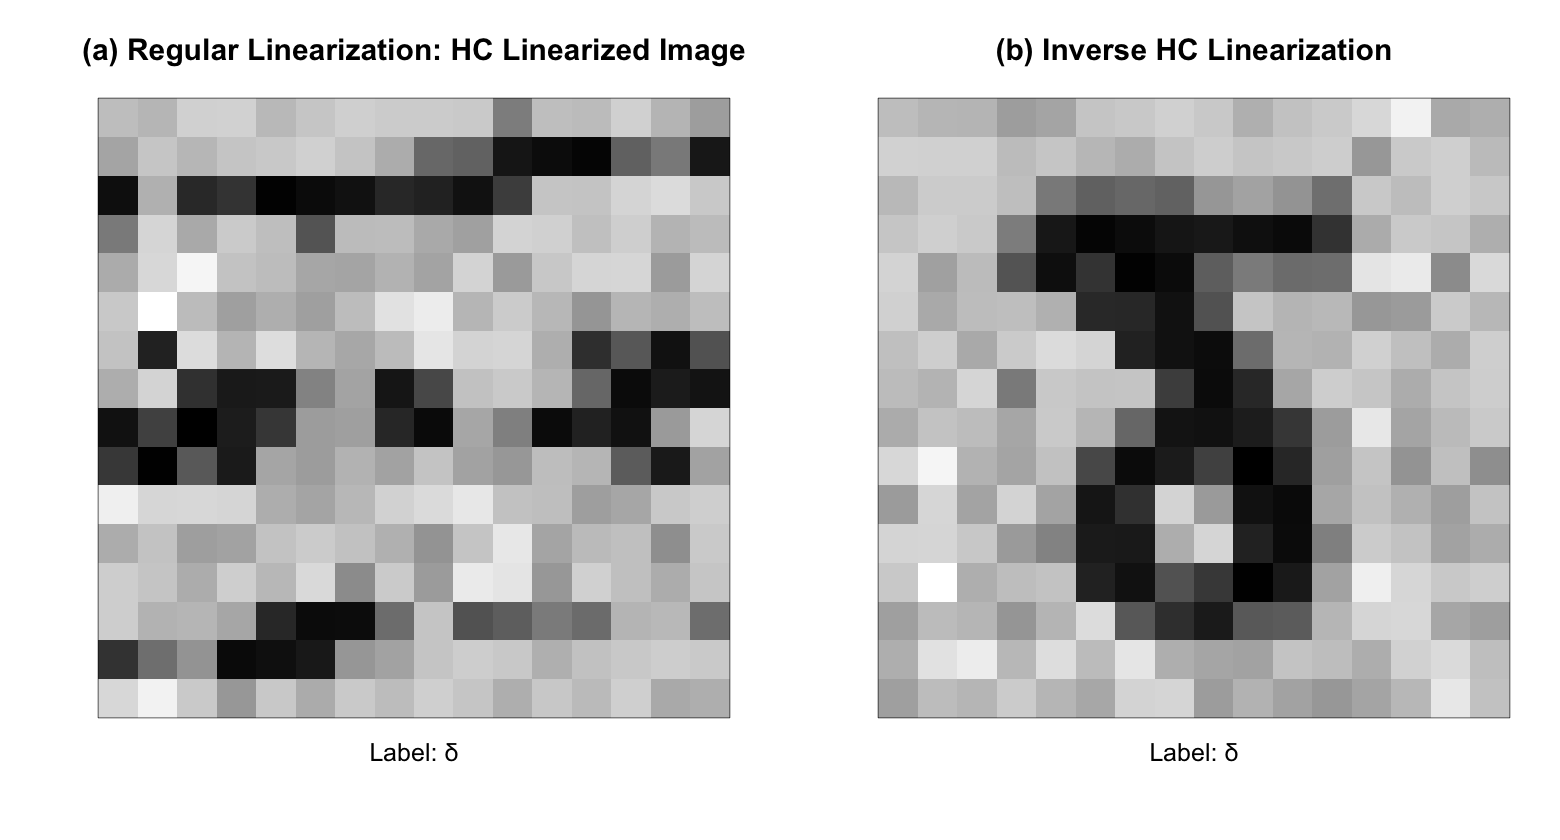

In [22]:
options(repr.plot.width = 13)
par(mfrow = c(1, 2))
random.i <- sample(seq_len(nrow(hilbert.data.set)), 1)

print('Figure 8: Image comparison between linearization methods')

show.image(hilbert.data.set, i = random.i,
           main = '(a) Regular Linearization: HC Linearized Image')
show.image(hilbert.data.set, i = random.i, hilbert = TRUE,
           main = '(b) Inverse HC Linearization')

Here's a comparison between the linearization methods (how the same image is represented in the data set):

In [23]:
regular.data.set |> slice(1)
hilbert.data.set |> slice(1)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X248,X249,X250,X251,X252,X253,X254,X255,X256,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.9998442,0.9878765,0.9831796,0.9862181,0.9729473,0.9837199,0.9850257,0.9907536,0.9845591,0.9858206,⋯,0.9516158,0.9724145,0.9632366,0.9704634,0.9597298,0.9771744,0.9967552,0.9887019,0.9741863,α


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X248,X249,X250,X251,X252,X253,X254,X255,X256,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.9998442,0.9878765,1,0.9911313,0.9695853,0.9692625,0.9921569,0.972549,1,0.9843137,⋯,0.972549,1,1,0.9618846,0.9917689,0.9564335,0.9764706,0.9617557,0.9935299,α


From above, the same image is represented differently in terms of the order.

#### Local Feature Representations

Now that we have two copies of our data sets ready to be trained, we have one last thing to do. Since our K-NN classification model uses Euclidean distance as its weight function, i.e. the distance between two images $x$ and $y$ is given by $\displaystyle d(x,y)=\sqrt{\sum_{i=1}^n(y_i-x_i)^2}$ where $y_i$ and $x_i$ are the features of the two images respectively, the distance between two HC linearized feature vectors will be exactly the same as that between two regularly linearized feature vectors because the Euclidean distance takes no account of the order in which the features are arranged so long as the same pieces of features are present. This means that if we were to train two instances of the model with the two data sets now, we would get two identical models that behave exactly the same. To ensure that linearization method play a part, we need a new set of image representations that embed the order information along with the data itself.

The easiest way to achieve this is by combining every feature with its immediate neighbor into a single feature by averaging them, that is, for each arc between two vertices of the linearization curve (i.e. two features/pixels), we compute an average to form a new feature: $x_i'=\dfrac{x_i+x_{i+1}}{2},\ 1≤i<n$ where $n\in\Z^+$ is the size of the feature vector ($16\times16=256$ in this case). This would result in feature vectors of size $n-1$.
Although a small portion of the data is lost during this compression process, the data now incorporates order information which is crucial to our experiment.

In [24]:
compress.image <- function(image.array) {
    ((lag(image.array, 1) + image.array) / 2) |>
        na.omit() |>
        as.numeric()
}

promised.new.size <- N ^ 2 - 1
transform.compress <- function(data.set) {
    data.set |> transform.set(compress.image, size = promised.new.size)
}

regular.compressed.set <- transform.compress(regular.data.set)
hilbert.compressed.set <- transform.compress(hilbert.data.set)

print('Table 8a: Regular linearization data set (compressed)')
head(regular.compressed.set, n = 3)
print('Table 8b: HC linearization data set (compressed)')
head(hilbert.compressed.set, n = 3)

[1] "Table 8a: Regular linearization data set (compressed)"


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X247,X248,X249,X250,X251,X252,X253,X254,X255,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.9938603,0.9855280,0.9846988,0.9795827,0.9783336,0.9843728,0.9878896,0.9876563,0.9851898,0.9901748,⋯,0.9709374,0.9620151,0.9678255,0.9668500,0.9650966,0.9684521,0.9869648,0.9927285,0.9814441,α
2,0.9878312,0.9744471,0.9803198,0.9992727,0.9959690,0.9775136,0.9718212,0.9843845,0.9879612,0.9862310,⋯,0.9810370,0.9973711,0.9731391,0.9643206,0.9723745,0.9743077,0.9812252,0.9885310,0.9787776,α
3,0.9623767,0.9633380,0.9628927,0.9655030,0.9629744,0.9725306,0.9764763,0.9741236,0.9647063,0.9556741,⋯,0.9772691,0.9843287,0.9898027,0.9827210,0.9692806,0.9674512,0.9651386,0.9783032,0.9854775,α


[1] "Table 8b: HC linearization data set (compressed)"


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X247,X248,X249,X250,X251,X252,X253,X254,X255,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.9938603,0.9939382,0.9955656,0.9803583,0.9694239,0.9807097,0.9823529,0.9862745,0.9921569,0.9843137,⋯,0.9862745,0.9862745,1.0000000,0.9809423,0.9768267,0.9741012,0.9664521,0.9691131,0.9776428,α
2,0.9878312,0.9880244,0.9754283,0.9772724,0.9819299,0.9761642,0.9862745,0.9960784,0.9980392,0.9980392,⋯,0.9882353,0.9784314,0.9901961,0.9774745,0.9737891,0.9901967,0.9938821,0.9936355,0.9775129,α
3,0.9623767,0.9651273,0.9587573,0.9573858,0.9608755,0.9622470,0.9784314,0.9882353,0.9823529,0.9941176,⋯,1.0000000,1.0000000,0.9921569,0.9682997,0.9562609,0.9579143,0.9738746,0.9869633,0.9760951,α


#### Stratified 5-fold Cross Validation

Now that the preprocessing is complete, we will now create a stratified 5-fold cross-validation split for both `regular.compressed.set` and `hilbert.compressed.set` via the function `vfold_cv`.
> Note that `vfold_cv` prevents us from performing a stratified 5-fold cross-validation on the given data with the `pool` argument set to any value greater than `0.04` (4%), this is a known issue and setting it to `0.04` (any value less than that will work, but it should be as large as possible) bypasses it but will trigger a warning, which will be ignored for the purposes of our experiment.

In [25]:
regular.cv <- vfold_cv(regular.compressed.set, v = 5, strata = label, pool = 0.04)
hilbert.cv <- vfold_cv(hilbert.compressed.set, v = 5, strata = label, pool = 0.04)

print('Regular Linearization CV:')
print(regular.cv |> select(id, splits))
print('HC Linearization CV:')
print(hilbert.cv |> select(id, splits))

Warning message:
“Stratifying groups that make up 4% of the data may be statistically risky.
• Consider increasing `pool` to at least 0.1”
Warning message:
“Stratifying groups that make up 4% of the data may be statistically risky.
• Consider increasing `pool` to at least 0.1”


[1] "Regular Linearization CV:"
#  5-fold cross-validation using stratification 
# A tibble: 5 × 2
  id    splits            
  <chr> <list>            
1 Fold1 <split [1344/336]>
2 Fold2 <split [1344/336]>
3 Fold3 <split [1344/336]>
4 Fold4 <split [1344/336]>
5 Fold5 <split [1344/336]>
[1] "HC Linearization CV:"
#  5-fold cross-validation using stratification 
# A tibble: 5 × 2
  id    splits            
  <chr> <list>            
1 Fold1 <split [1344/336]>
2 Fold2 <split [1344/336]>
3 Fold3 <split [1344/336]>
4 Fold4 <split [1344/336]>
5 Fold5 <split [1344/336]>


Here's a class distribution of the first split within the cross validation set for the Baseline Condition:

In [26]:
print('Table 9: Class distribution for \'regular.cv - split 1\'')
regular.cv$splits[[1]] |> training() |>
    group_by(label) |>
    summarize(training = n()) |>
    bind_cols(testing = regular.cv$splits[[1]] |>
                  testing() |>
                  group_by(label) |>
                  summarize(testing = n()) |>
                  select(testing)) |>
    mutate(total = training + testing)

[1] "Table 9: Class distribution for 'regular.cv - split 1'"


label,training,testing,total
<fct>,<int>,<int>,<int>
α,56,14,70
β,56,14,70
γ,56,14,70
δ,56,14,70
ε,56,14,70
ζ,56,14,70
η,56,14,70
θ,56,14,70
ι,56,14,70


### Training and Evaluating the Model

Now we will train and evaluate the model using both methods for all $K\in[2,51]$
using `tune_grid`.

Both models will share the same specifications:

In [27]:
model.spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune(),
                               engine = 'kknn', mode = 'classification')
model.spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


For simplicity, we will create a helper function to train and evaluate a model and return a tuning result object that can be further used for analysis.

In [28]:
evaluate.model <- function(spec, resamples) {
    # grid values
    k.vals <- tibble(neighbors = 2:51)
    # control: for extracting predictions (confusion matrix)
    control <- control_resamples(save_pred = TRUE)
    # create a workflow and tune
    tune.results <- workflow() |>
        add_formula(label ~ .) |>
        add_model(spec) |>
        tune_grid(resamples = resamples, grid = k.vals, control = control)
    return(tune.results)
}

We first evaluate the Baseline Model:

In [29]:
regular.tune <- evaluate.model(model.spec, regular.cv)

# get accuracy metrics
regular.metrics <- regular.tune |>
    collect_metrics() |>
    filter(.metric == 'accuracy')

print('Table 10a: Tuning metrics preview (Regular)')
head(regular.metrics)

[1] "Table 10a: Tuning metrics preview (Regular)"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.9357143,5,0.007386711,Preprocessor1_Model01
3,accuracy,multiclass,0.9148810,5,0.008019163,Preprocessor1_Model02
4,accuracy,multiclass,0.9101190,5,0.007130446,Preprocessor1_Model03
5,accuracy,multiclass,0.8928571,5,0.009316950,Preprocessor1_Model04
6,accuracy,multiclass,0.8827381,5,0.012717774,Preprocessor1_Model05
7,accuracy,multiclass,0.8684524,5,0.011309524,Preprocessor1_Model06


And now we evaluate the HC Model:

In [30]:
hilbert.tune <- evaluate.model(model.spec, hilbert.cv)

# get accuracy metrics
hilbert.metrics <- hilbert.tune |>
    collect_metrics() |>
    filter(.metric == 'accuracy')

print('Table 10b: Tuning metrics preview (HC)')
head(hilbert.metrics)

[1] "Table 10b: Tuning metrics preview (HC)"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.9339286,5,0.0021870444,Preprocessor1_Model01
3,accuracy,multiclass,0.9107143,5,0.0009411541,Preprocessor1_Model02
4,accuracy,multiclass,0.9035714,5,0.0020185506,Preprocessor1_Model03
5,accuracy,multiclass,0.8964286,5,0.0023809524,Preprocessor1_Model04
6,accuracy,multiclass,0.8892857,5,0.0055200110,Preprocessor1_Model05
7,accuracy,multiclass,0.8732143,5,0.0045721106,Preprocessor1_Model06


To compare the performance of the two models, we will extract the confusion matrix from the tune result object and take a look. Here's a helper function created for that purpose:

In [31]:
avg.confusion.matrix <- function(tune.results, k) {
    # get tidied confusion matrix as data frame
    conf.mat <- tune.results |>
        conf_mat_resampled(parameters = tibble(neighbors = k)) |>
        pivot_wider(names_from = Truth, values_from = Freq) |>
        as.data.frame()
    
    # set Prediction column as rownames
    conf.mat <- conf.mat |>
        `rownames<-`(conf.mat$Prediction) |>
        select(-Prediction)
    
    return(conf.mat)
}

We will now extract and analyze the confusion matrix for $K=3$ for the Baseline Condition.

In [32]:
options(repr.matrix.max.cols = 24)
print('Table 11a: Confusion Matrix (K = 3, Regular Linearization)')
regular.tune |>
    avg.confusion.matrix(k = 3)

options(repr.matrix.max.cols = 20)

[1] "Table 11a: Confusion Matrix (K = 3, Regular Linearization)"


,α,β,γ,δ,ε,ζ,η,θ,ι,κ,λ,μ,ν,ξ,ο,π,ρ,σ,τ,υ,φ,χ,ψ,ω
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
α,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
β,0,13.4,0.0,1.6,0.4,0.2,0.0,0.4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
γ,0,0.0,13.2,0.2,0.0,0.4,0.0,0.0,0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
δ,0,0.2,0.2,11.2,0.0,0.2,0.0,0.2,0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0,0.2,0.0,0.0,0.0,0,0.0
ε,0,0.2,0.0,0.2,11.6,0.2,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.2,0.0,0.0,0,0.6
ζ,0,0.0,0.0,0.0,0.0,10.2,0.0,0.2,0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
η,0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0,0.0,0.0,0.0,0.0,0,0.0
θ,0,0.0,0.0,0.0,0.0,0.4,0.0,11.8,0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
ι,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0,0.4,0.0,0.0,0.2,0,0.0


From the confusion matrix, it is evident that the model did a perfect job classifying the Greek letters $\alpha$, $\iota$, $\sigma$, and $\psi$. It is surprising that the Baseline Model did not seem to confuse $\alpha$ and $\sigma$ since the two are quite similar rotation- and feature-wise (a rounded glyph with a short edge coming out). For the infamous pair $\phi$ and $\psi$, the model confuses $\phi$ with $\psi$ a lot but not the other way around. The Baseline Model performed submaximally for greek letters $\rho$, $o$, and $\upsilon$ with a high average correct classification frequency of 13.8, among which $\rho$ and $o$ share similar features with $\alpha$ and $\sigma$ and could be a potential explanation for such high accuracy. In addition, the Baseline Model performed the most poorly with greek letters $\zeta$ and $\kappa$. For $\zeta$, the model gets confused and struggles to correctly identify $\zeta$ from $\xi$, which, admittedly, are quite similar. For $\kappa$, it sometimes confuse it for $\pi$ and $\lambda$, which are quite reasonable since they share the similar pattern of three similar-length line segments joined in different positions. Overall, the model's performance was quite decent and desirable for such a simplistic and intuitive algorithm.

We will now extract and analyze the confusion matrix for $K=3$ for the HC Condition.

In [33]:
options(repr.matrix.max.cols = 24)
print('Table 11b: Confusion Matrix (K = 3, HC Linearization)')
hilbert.tune |>
    avg.confusion.matrix(k = 3)

options(repr.matrix.max.cols = 20)

[1] "Table 11b: Confusion Matrix (K = 3, HC Linearization)"


,α,β,γ,δ,ε,ζ,η,θ,ι,κ,λ,μ,ν,ξ,ο,π,ρ,σ,τ,υ,φ,χ,ψ,ω
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
α,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
β,0,12.8,0.0,2.0,0.0,0.0,0.0,0.6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
γ,0,0.2,13.8,0.0,0.0,0.2,0.0,0.0,0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
δ,0,0.4,0.0,11.2,0.0,0.2,0.0,0.0,0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.2
ε,0,0.4,0.0,0.0,11.6,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.8
ζ,0,0.0,0.0,0.0,0.0,9.2,0.0,0.0,0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
η,0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.2,0.2,0.0,0,0.0,0.0,0.0
θ,0,0.0,0.0,0.0,0.0,0.4,0.0,12.2,0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
ι,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0,0.0,0.0,0.0


Like the Baseline Model, the HC model does a perfect job classifying $\alpha$ and $\iota$. However, it no longer perfectly tell $\psi$ apart from $\phi$ and does a horrible job classifying $\phi$ (with a subminimal average correct classification frequency of 10). Besides that, the HC Model performs the most poorly on letters $\delta$ and $\zeta$, confusing them both with $\xi$ quite a lot, which are indeed similar in terms of the local features: body curvature and the little "hat" thing on top of the letters. Another noticeable thing is that the model tends to occasionally confuse $\epsilon$ and $\omega$ on a slightly higher average frequency than that of the Baseline Model (2.2 vs. 2.0 and 0.8 vs. 0.6 for HC Model and Baseline Model respectively). The two are very difficult to tell apart due to data augmentation and their inherent features: the model is trained on data that has rotated samples of both letters, and that $\epsilon$ highly resembles a clockwise-90-degrees-rotated $\omega$ (the same for the other way around), especially when they are handwritten. This could be an indicator that the embedding of local features using the Hilbert curve to some extent reinforced and made a difference as to how the model perceives the local image features.

To compare the models' average frequencies of correct classifications by class:

In [34]:
conf.mat.params <- tibble(neighbors = 2)
regular.tune |>
    conf_mat_resampled(parameters = conf.mat.params) |>
    filter(Prediction == Truth) |>
    select(-Prediction) |>
    bind_cols(hilbert.tune |>
                  conf_mat_resampled(parameters = conf.mat.params) |>
                  filter(Prediction == Truth) |>
                  select(Freq), .name_repair = 'minimal') |>
    `colnames<-`(c('label', 'regular', 'hilbert'))

label,regular,hilbert
<fct>,<dbl>,<dbl>
α,14.0,14.0
β,13.4,13.0
γ,13.0,13.8
δ,12.6,12.0
ε,12.4,12.6
ζ,11.0,10.2
η,12.2,12.6
θ,12.2,11.8
ι,14.0,14.0


On average, the two models perform the same for $\alpha$, $\iota$, $\zeta$, $\upsilon$, $\chi$, and $\omega$ (6 classes). The HC Model outperforms the Baseline Model for 10 classes and was outperformed by the Baseline Model for 8 classes. With neither of the model being clearly dominant in terms of the average correct classification frequencies (the HC Model is slightly better based on the above summary), it's better to conclude that they each have their own distinct characteristics.

To better compare the performance of the two models across all $K\in[2,51]$, we will create an Accuracy vs. $K$ line plot to visualize the differences. The area between the lines will be shaded with the color of whichever has the higher accuracy measure at that particular point $K$ to indicate dominance.

We first compute the within-pair differences for plotting and later on for hypothesis test:

In [35]:
paired.df <- regular.metrics |>
    select(neighbors, mean) |>
    bind_cols(hilbert.metrics |> select(mean), .name_repair = 'minimal') |>
    `colnames<-`(c('neighbors', 'regular', 'hilbert')) |>
    mutate(delta = hilbert - regular)

print('Table 12: Difference data frame for paired observations')
paired.df

[1] "Table 12: Difference data frame for paired observations"


neighbors,regular,hilbert,delta
<int>,<dbl>,<dbl>,<dbl>
2,0.9357143,0.9339286,-0.0017857143
3,0.9148810,0.9107143,-0.0041666667
4,0.9101190,0.9035714,-0.0065476190
5,0.8928571,0.8964286,0.0035714286
6,0.8827381,0.8892857,0.0065476190
7,0.8684524,0.8732143,0.0047619048
8,0.8595238,0.8630952,0.0035714286
9,0.8452381,0.8571429,0.0119047619
10,0.8404762,0.8517857,0.0113095238


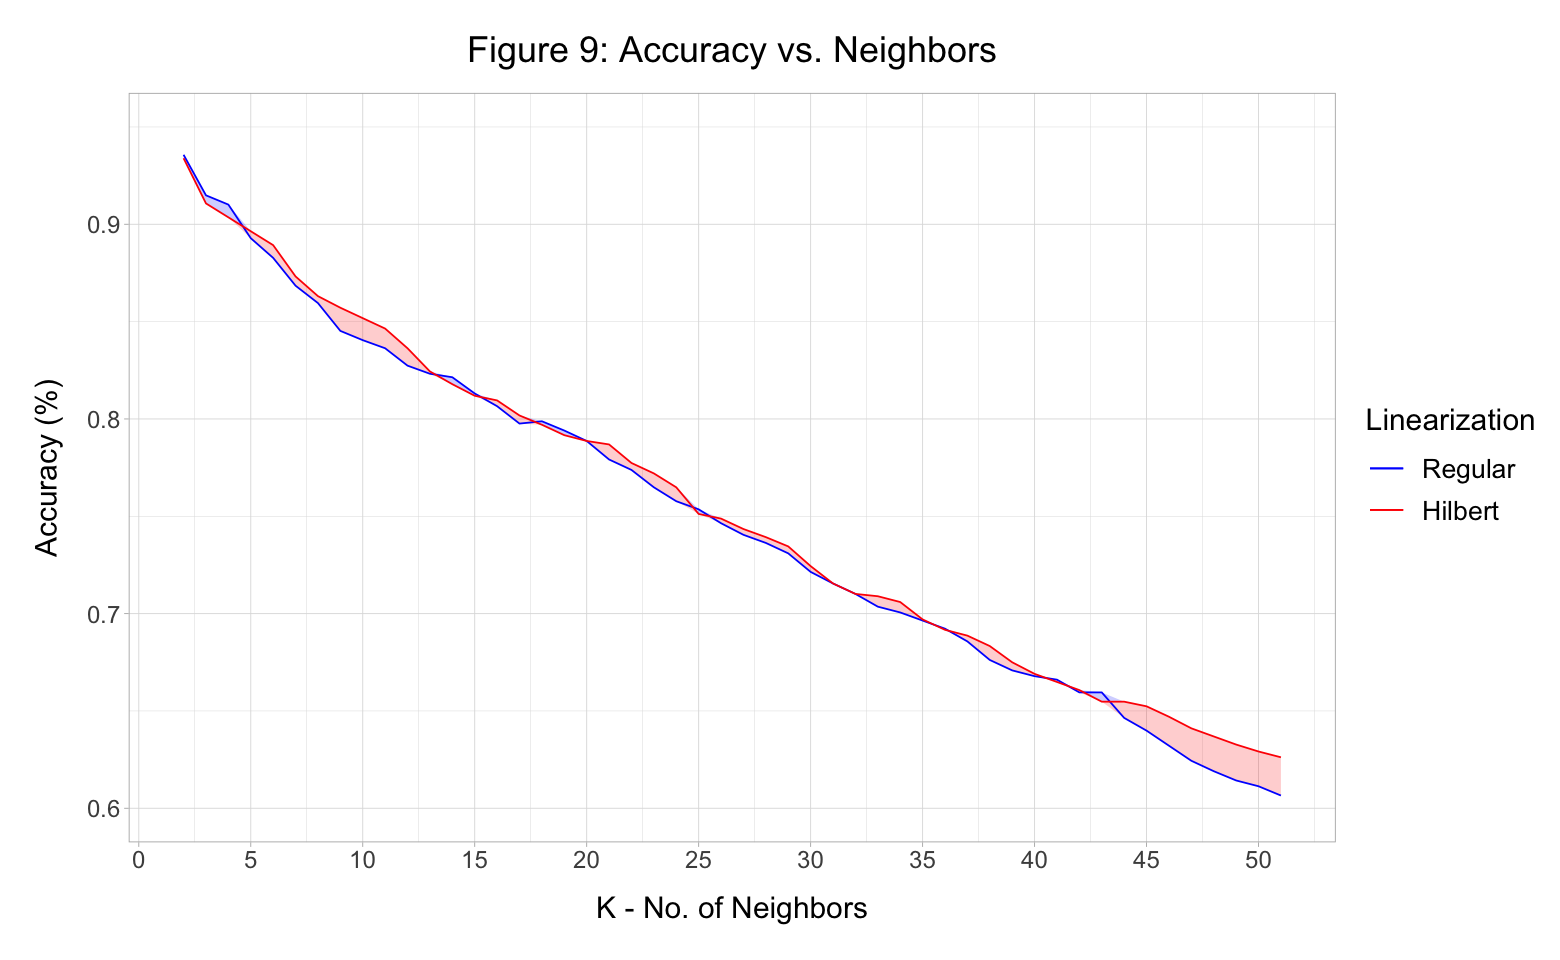

In [36]:
options(repr.plot.width = 13, repr.plot.height = 8)
paired.df |> ggplot(aes(x = neighbors)) +
    geom_ribbon(aes(ymin = pmin(regular, hilbert), ymax = hilbert),
                fill = 'red', alpha = 0.2) +
    geom_ribbon(aes(ymin = hilbert, ymax = pmax(regular, hilbert)),
                fill = 'blue', alpha = 0.2) +
    geom_line(aes(y = regular, color = 'Regular')) +
    geom_line(aes(y = hilbert, color = 'Hilbert')) +
    scale_color_manual(breaks = c('Regular', 'Hilbert'),
                       values = c('blue', 'red')) +
    scale_x_continuous(breaks = seq(0, 51, 5)) +
    scale_y_continuous(breaks = seq(0.6, 1, 0.1), limits = c(0.6, 0.95)) +
    labs(title = 'Figure 9: Accuracy vs. Neighbors',
         x = 'K - No. of Neighbors', y = 'Accuracy (%)',
         color = 'Linearization') +
    theme_light() +
    theme(text = element_text(size = 18),
          plot.title = element_text(hjust = 0.5, margin = unit(c(0, 0, 0.5, 0), 'cm')),
          axis.title.x = element_text(margin = unit(c(0.5, 0, 0, 0), 'cm')),
          axis.title.y = element_text(margin = unit(c(0, 0.5, 0, 0), 'cm')),
          legend.key.size = unit(25, 'pt'),
          legend.text = element_text(size = 16),
          legend.margin = margin(l = 0.25, unit = 'cm'),
          plot.margin = margin(t = 0.75, b = 0.75, l = 0.75, r = 0.5, unit = 'cm'))

From the line plot, it is evident (and expected) that there exists a negative association between the accuracy and the number of neighbors ($K$): with a high of about 95% accuracy and a low down to almost 60%, the accuracy measure decreases rather quickly as the number of neighbors increases.

Although not strictly consistent throughout all $K\in[2,51]$, it appears that for the majority of the $K$ values (except for $2≤K<5$ and a few other $K$ values), the Hilbert Model's accuracy transcended that of the Baseline Model.

To see the distribution of the accuracy differences, we will plot a histogram with an overlaying KDE curve on top to outline the shape of the distribution.

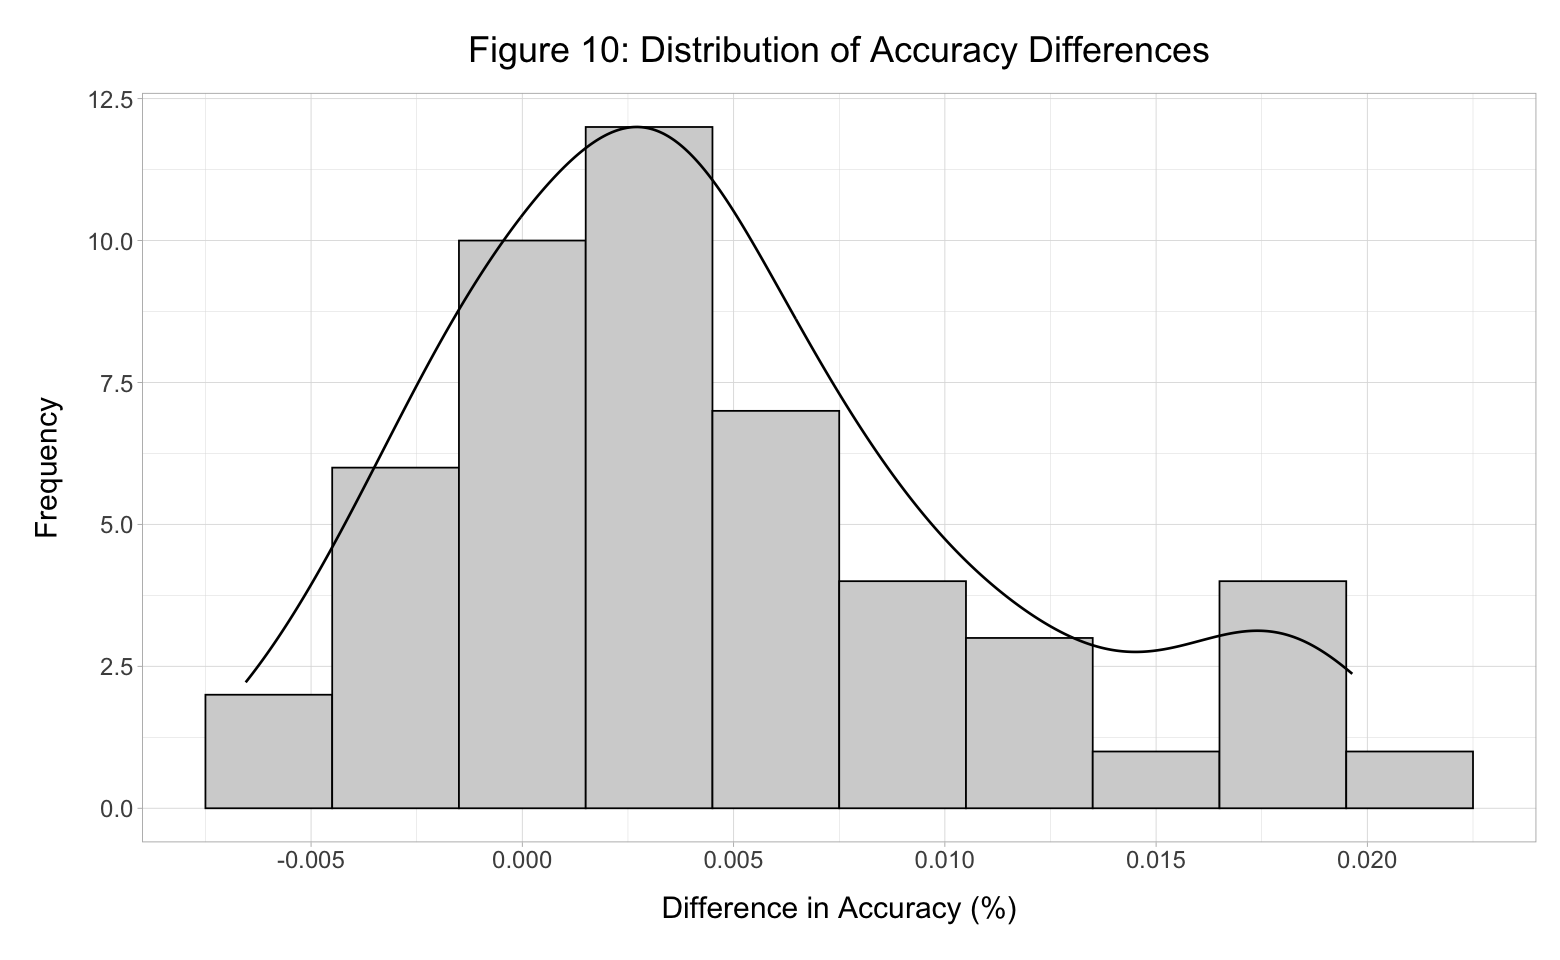

In [37]:
options(repr.plot.width = 13, repr.plot.height = 8)
paired.df |> ggplot(aes(x = delta)) +
    geom_histogram(binwidth = 0.003, fill = 'lightgray', color = 'black', na.rm = TRUE) +
    geom_density(aes(y = 0.0035 * after_stat(count)), linewidth = 0.75) +
    scale_x_continuous(breaks = seq(-0.02, 0.02, 0.005)) +
    labs(title = 'Figure 10: Distribution of Accuracy Differences',
         x = 'Difference in Accuracy (%)', y = 'Frequency') +
    theme_light() +
    theme(text = element_text(size = 18),
          plot.title = element_text(hjust = 0.5, margin = unit(c(0, 0, 0.5, 0), 'cm')),
          axis.title.x = element_text(margin = unit(c(0.5, 0, 0, 0), 'cm')),
          axis.title.y = element_text(margin = unit(c(0, 0.5, 0, 0), 'cm')),
          plot.margin = margin(t = 0.75, b = 0.75, l = 0.75, r = 0.5, unit = 'cm'))

From the distribution, the shape tends to be moderately right-skewed, with most of the accuracy differences between 0% to 0.5% and very roughly (by the Empirical Rule) 68% of the data spreading over the interval $[0.0,0.01]$ (0% to 1%). There is also a secondary peak between $[0.015,0.020]$ (1.5% to 2%). Obviously, most (approximately over 80%) of the data are distributed over positive differences (to the right of 0%).

However, the above visualizations and analyses are not sufficient to draw a conclusion: it does not necessarily mean that the performance of the HC Model significantly outperforms the Baseline Model at all occasions -- it could be that this result is specific to this particular sample and the test is inconclusive without a proper significance test.

### Hypothesis Testing

With all the available data, we will now proceed to perform the right-tailed paired $t$-test at a significance level $\alpha=0.05$ (95% confidence level):

In [38]:
t.test(paired.df$hilbert, paired.df$regular,
       paired = TRUE, alternative = 'greater')


	Paired t-test

data:  paired.df$hilbert and paired.df$regular
t = 5.1084, df = 49, p-value = 2.664e-06
alternative hypothesis: true mean difference is greater than 0
95 percent confidence interval:
 0.003135088         Inf
sample estimates:
mean difference 
    0.004666667 


Let $\Delta_{acc}$ be the population mean difference and $\hat{\Delta}_{acc}$ be the sample mean difference, under the assumption that the null hypothesis $H_0$ is true, $\hat{\Delta}_{acc}\ \dot\sim\ \mathcal{N}\left(\Delta_{acc},\dfrac{{\sigma_\Delta}^2}{n}\right)$ where $\Delta_{acc}=0$ (by $H_0$), $\sigma_\Delta$ is the standard deviation of population mean difference, and $n$ is the sample size. Let $t$ be the standardized sample mean accuracy difference between the Baseline Model and the HC Model under the assumption that $H_0$ is true, such that $t\sim t_{n-1}$ where $t_{n-1}$ is a $t$-model with $n-1$ degrees of freedom and $n$ is the sample size. In this case, since $n=50$, $t$ follows a $t$-model with $49$ degrees of freedom ($t_{49}$).

The statistic $t$ is given by $t=\dfrac{\hat{\Delta}_{acc}-\Delta_{acc}}{\hat{\sigma}_\Delta/\sqrt{n}}=5.1084$ (provided by `t.test`), and the corresponding right-tailed $p$-value is $2.66\times10^{-6}$, which follows that $p\text{-value}<\alpha$.

Therefore, the null hypothesis $H_0$ is **rejected**. We have sufficient evidence that the mean population difference between the two models' accuracies is significantly greater than the hypothesized $0$. This means that the use of Hilbert curve linearization as a measure to capture local features of images does significantly improves the accuracy of the K-NN model on a Greek Alphabet classification task.

### Discussions

The integration of the Hilbert curve enhances the model's overall performance and aids in capturing the underlying spatial patterns and dependencies inherent within the data. By maintaining the proximity of neighboring points, the curve effectively retains the local structures present in the data. Traditional distance metrics, like the Euclidean distance used in a conventional K-NN model, become less effective as the number of dimensions increases, leading to decreased classification performance. Hilbert linearization, however, enables more effective distance computations, accounting not only for individual features, but also the preserved local features grouped in the transformed space.

This finding aligns with our initial postulation that the application of the Hilbert curve in K-NN classification models introduces locality preservation property which has significant implications for improving the model's performance. However, we were not sure of the extent to which the K-NN classification model would utilize this property of the Hilbert curve and whether the impact is sufficiently noteworthy. This finding highlights the practicality of incorporating the Hilbert curve in K-NN classification models, suggests its potential for improving performance in various pattern recognition applications, and brings so many more implications and future endeavors.

There could be so many more future studies regarding finding the optimal linearization method for specific problems and how the linearization method interact with the other hyperparameters when training a model to suit certain tasks. Since the underlying relationships remain to be discovered, future research and/or contemporary literature shall strive to investigate these mathematical/systematic relationships not just in experimental conditions but also in theoretical contexts.

### References

<div style="padding-left: 30px; text-indent: -30px;">
Amato, G., & Falchi, F. (2010). kNN based image classification relying on local feature similarity. Paper presented at the 101-108. <a href="https://doi.org/10.1145/1862344.1862360">https://doi.org/10.1145/1862344.1862360</a>
</div>
<div style="padding-left: 30px; text-indent: -30px;">
Assegie, T. A. (2022). An effective approach for determining sample size that optimizes the performance of classifier: determining sample size that optimizes the performance of classifier. <i>International Journal of Intelligent Systems and Applications in Engineering, 10</i>(2), 222-225.
</div>
<div style="padding-left: 30px; text-indent: -30px;">
Kontolati, K. (2020). <i>Classification of Handwritten Greek Letters</i>, Version 1 [Data set]. Retrieved June 17, 2023 from <a href="https://www.kaggle.com/datasets/katianakontolati/classification-of-handwritten-greek-letters">https://www.kaggle.com/datasets/katianakontolati/classification-of-handwritten-greek-letters</i>.
</div>
<div style="padding-left: 30px; text-indent: -30px;">
Moon, B., Jagadish, H. V., Faloutsos, C., & Saltz, J. H. (2001). Analysis of the clustering properties of the hilbert space-filling curve. <i>IEEE Transactions on Knowledge and Data Engineering, 13</i>(1), 124-141. <a href="https://doi.org/10.1109/69.908985">https://doi.org/10.1109/69.908985</a>
</div>